In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Chatbot 소스 코드 복사
!git clone --recurse-submodules https://github.com/dpflawl/Chatbot.git

In [ ]:
# 폴더 이동
%cd Chatbot

In [ ]:
!pip install -r requirements_chatbot.txt

# 챗봇 모델 생성 
(https://github.com/haven-jeon/KoGPT2-chatbot) 참조 (KoGPT2를 챗봇 데이터 파인튜닝하는 코드)

In [ ]:
# 사전훈련된 KoGPT2를 챗봇 데이터로 파인튜닝
!CUDA_VISIBLE_DEVICES=0 python chatbot.py --train --gpus 1 --max_epochs 10

- 학습이 불가능한 경우)
- 제가 학습시켜서 추출한 모델을 직접 다운 받아서 model 파일 밑에 위치시켜주세요!
https://drive.google.com/file/d/17jWPP5pbhj67RqIuzIbuBnOznTgG2STy/view?usp=sharing

# 감정 분류 모델 생성

## 1.데이터불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
train_data = pd.read_csv('/data/naver_review_train.txt', sep ="\t")
test_data = pd.read_csv('/data/naver_review_test.txt', sep = "\t")

In [ ]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터정제하기


In [ ]:
#중복된 documnet있음. 제거 필요함
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [ ]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [ ]:
train_data['label'].value_counts()

0    73342
1    72841
Name: label, dtype: int64

In [ ]:
#null값확인
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [ ]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [ ]:
#Null값제거
train_data = train_data.dropna(how = 'any')

In [ ]:
#전처리중 하나로 정규표현식으로 기호, 부호등 모두 제거실시
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [ ]:
train_data['document'] = train_data['document'].str.replace('^ +', "") 

# white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)

print(train_data.isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


id            0
document    789
label         0
dtype: int64


In [ ]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [ ]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [ ]:
## 테스트 데이터에도 동일하게 적용함

test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


전처리 후 테스트용 샘플의 개수 : 48852


## 3. 토큰화하기
 * 불용어제거(조사 접속사등)
 * 토크나이징실시

In [ ]:
#불용어 정의 제거

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
# 토큰나이징 정의

okt = Okt()

In [ ]:
# 트레인데이터셋에서 불용어 제거및 okt 적용

X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [12:35<00:00, 192.34it/s]


In [ ]:
# 테스트데이터셋에서 불용어 제거및 okt 적용

X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [04:40<00:00, 174.28it/s]


## 4. 정수인코딩
* 각각의 토큰들에 수치부여하여 컴퓨터가 알아먹도록 함

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

In [ ]:
# tokenizer 한 통계 갯수 구함 (별로 안나오는 단어등)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [ ]:
#빈도가 적은 희귀 단어는 제거하여 X 값을 줄이는게 필요
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


In [ ]:
#다시 Vocab 사이즈 기반으로 토크나이징 한후 각각의 토큰이 정수할당후 이 수치를 이용하여 각문장을 정수로 변환

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
#희귀한 단어로만 된 문장의 경우 블랭크이느로 이를 제거

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145162
145162


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## 5. 패딩
* 서로 다른 길이의 샘플들을 길이를 동일하게 맞춰는 작업. 전체 분포 보고 결정하면됨

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


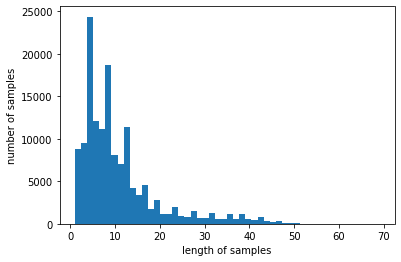

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## 6. LSTM으로 감성분류하기

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1815/1815 [==============================] - ETA: 0s - loss: 0.3908 - acc: 0.8219
Epoch 1: val_acc improved from -inf to 0.84693, saving model to best_model.h5
1815/1815 [==============================] - 182s 96ms/step - loss: 0.3908 - acc: 0.8219 - val_loss: 0.3491 - val_acc: 0.8469
Epoch 2/15
1815/1815 [==============================] - ETA: 0s - loss: 0.3279 - acc: 0.8578
Epoch 2: val_acc improved from 0.84693 to 0.85530, saving model to best_model.h5
1815/1815 [==============================] - 174s 96ms/step - loss: 0.3279 - acc: 0.8578 - val_loss: 0.3337 - val_acc: 0.8553
Epoch 3/15
1815/1815 [==============================] - ETA: 0s - loss: 0.3019 - acc: 0.8712
Epoch 3: val_acc improved from 0.85530 to 0.85992, saving model to best_model.h5
1815/1815 [==============================] - 174s 96ms/step - loss: 0.3019 - acc: 0.8712 - val_loss: 0.3253 - val_acc: 0.8599
Epoch 4/15
1815/1815 [==============================] - ETA: 0s - loss: 0.2836 - acc: 0.8820
Epoch 4: v

- 학습이 불가능한 경우)
- 제가 학습시켜서 추출한 모델을 직접 다운 받아서 model 파일 밑에 위치시켜주세요!
https://drive.google.com/file/d/1SpKHGyaCnKaqpJs2Kbo-S9dvR9QQgghJ/view?usp=sharing

In [ ]:
loaded_model = load_model('model/best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 23s 15ms/step - loss: 0.3343 - acc: 0.8573

 테스트 정확도: 0.8573


## 8. 신규 데이터로 예측해보기


In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('너무 힘들어.')

97.73% 확률로 부정 리뷰입니다.



# 감정 모델 기반의 챗봇 (테스트)

In [ ]:
# 감정 모델이 포함되지 않은 챗봇 결과

INFO:root:Namespace(accelerator=None, accumulate_grad_batches=1, amp_backend='native', amp_level='O2', auto_lr_find=False, auto_scale_batch_size=False, auto_select_gpus=False, automatic_optimization=None, batch_size=96, benchmark=False, chat=True, check_val_every_n_epoch=1, checkpoint_callback=True, default_root_dir=None, deterministic=False, distributed_backend=None, enable_pl_optimizer=None, fast_dev_run=False, flush_logs_every_n_steps=100, gpus=1, gradient_clip_val=0, limit_predict_batches=1.0, limit_test_batches=1.0, limit_train_batches=1.0, limit_val_batches=1.0, log_every_n_steps=50, log_gpu_memory=None, logger=True, lr=5e-05, max_epochs=None, max_len=32, max_steps=None, min_epochs=None, min_steps=None, model_params='model/model_-last.ckpt', move_metrics_to_cpu=False, multiple_trainloader_mode='max_size_cycle', num_nodes=1, num_processes=1, num_sanity_val_steps=2, overfit_batches=0.0, plugins=None, precision=32, prepare_data_per_node=True, process_position=0, profiler=None, progr

In [ ]:
# # 감정 모델이 포함된 챗봇 결과
!CUDA_VISIBLE_DEVICES=0 python chatbot.py --gpus 1 --chat

INFO:root:Namespace(accelerator=None, accumulate_grad_batches=1, amp_backend='native', amp_level='O2', auto_lr_find=False, auto_scale_batch_size=False, auto_select_gpus=False, automatic_optimization=None, batch_size=96, benchmark=False, chat=True, check_val_every_n_epoch=1, checkpoint_callback=True, default_root_dir=None, deterministic=False, distributed_backend=None, enable_pl_optimizer=None, fast_dev_run=False, flush_logs_every_n_steps=100, gpus=1, gradient_clip_val=0, limit_predict_batches=1.0, limit_test_batches=1.0, limit_train_batches=1.0, limit_val_batches=1.0, log_every_n_steps=50, log_gpu_memory=None, logger=True, lr=5e-05, max_epochs=None, max_len=32, max_steps=None, min_epochs=None, min_steps=None, model_params='model/model_-last.ckpt', move_metrics_to_cpu=False, multiple_trainloader_mode='max_size_cycle', num_nodes=1, num_processes=1, num_sanity_val_steps=2, overfit_batches=0.0, plugins=None, precision=32, prepare_data_per_node=True, process_position=0, profiler=None, progr

- 현재는 영화 리뷰데이터를 기반으로 학습된 모델을 사용하였음에도 어느정도 감정을 잘 분석하였음
- 일상대화용 감정분석을 위해 AI HUB '한국어 감정 정보가 포함된 단발성 대화 데이터셋'으로 모델을 학습하면 성능이 향상될 것 같음
- 참고하면 좋을 논문 링크: https://www.koreascience.or.kr/article/CFKO202025036019264.pdf